Check effect of Negative Voja learning rule on MEG response

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja

# 2D

## Setup

In [6]:
n_neurons = 100
n_items = 16
dimensions = 2
seed = 8

intercepts = [0.8]*n_neurons
rad_comp = 1/np.sqrt(2)

In [5]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=10)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=11)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=12)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=13)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=14)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=15)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/voc

In [14]:
fan1_pairs = np.array(fan1_pair_vecs)
fan2_pairs = np.array(fan2_pair_vecs)
fan1_mean = np.mean(fan1_pair_vecs, axis=0)
fan2_mean = np.mean(fan2_pair_vecs, axis=0)

(-1.1, 1.1)

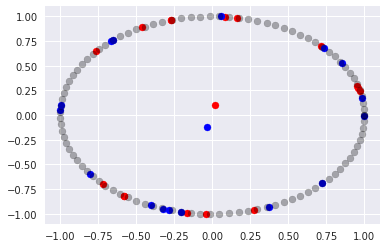

In [15]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

plt.scatter(fan1_pairs[:, 0], fan1_pairs[:, 1], label="cluster", color='r')
plt.scatter(fan1_mean[0], fan1_mean[1], color='r')
plt.scatter(fan2_pairs[:, 0], fan2_pairs[:, 1], label="spread", color='b')
plt.scatter(fan2_mean[0], fan2_mean[1], color='b')
plt.scatter(enc[:, 0], enc[:, 1], color='k', alpha=0.3)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

## Simulation

In [8]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders
neg_voja = NegVoja(enc, learning_rate=1e-5)

Building finished in 0:00:01.                                                   


In [16]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

n_repeats = 1
t_pause = 0.4
t_present = 0.3
t_each = t_pause + t_present

dt = 0.001

In [11]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, D, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)

    neg_voja = NegVoja(enc, learning_rate=1e-5)
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(1)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 


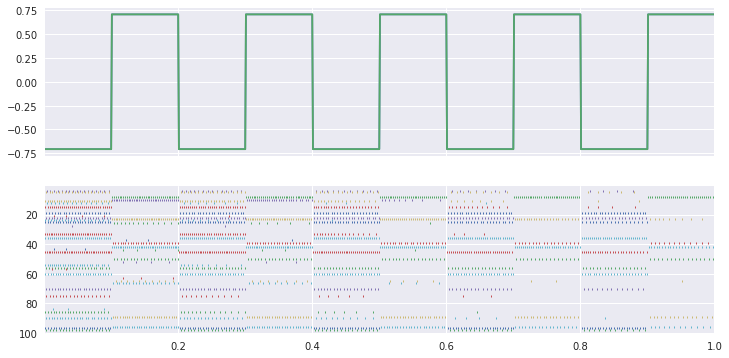

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(sim.trange(), sim.data[p_in])
rasterplot(sim.trange(), sim.data[p_spikes], ax=ax2)

In [ ]:
meg_sig = meg_from_spikes(sim.data[p_spikes])